In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
import pytorch_lightning as pl
import torch
from torch import nn
import torchvision.models as models
from pytorch_lightning.metrics import MetricCollection, Accuracy, Precision, Recall, ConfusionMatrix, PrecisionRecallCurve
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [43]:
class ImEncodeModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Sequential()
#         for name, param in self.image_model.named_parameters():
#             if "layer4.1" not in name:
#                 print(name)
#                 param.requires_grad = False
        
        self.triplet_loss = nn.TripletMarginLoss(margin=5.0, p=2)
    
    
    def forward(self, input_image):
        encoding = self.image_model(input_image)
        return encoding
    
    def training_step(self, batch, batch_idx):
        encoded_positive_image = self.forward(batch['positive image'])
        encoded_negative_image = self.forward(batch['negative image'])
        encoded_unknown_image  = self.forward(batch['unknown image'])

        trip_loss = self.triplet_loss(encoded_unknown_image, encoded_positive_image, encoded_negative_image)
        self.log("tr/loss", trip_loss)
        
        return trip_loss

    def validation_step(self, batch, batch_idx):
        encoded_positive_image = self.forward(batch['positive image'])
        encoded_negative_image = self.forward(batch['negative image'])
        encoded_unknown_image  = self.forward(batch['unknown image'])

        trip_loss = self.triplet_loss(encoded_unknown_image, encoded_positive_image, encoded_negative_image)
        self.log("val/loss", trip_loss)
        
        return trip_loss
    
    def test_step(self, batch, batch_idx):
        
        encoded_positive_image = self.forward(batch['positive image'])
        encoded_negative_image = self.forward(batch['negative image'])
        encoded_unknown_image  = self.forward(batch['unknown image'])

        trip_loss = self.triplet_loss(encoded_unknown_image, encoded_positive_image, encoded_negative_image)
        self.log("test/loss", trip_loss)
        
        return trip_loss

        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [44]:
from triplet_loss_datamodule import ZeroShotDataModule
dm = ZeroShotDataModule(batch_size = 64, 
                        test_plants = 'all', 
                        train_plants = [ 'Strawberry', 'Tomato'])
dm.setup()

plants in this dataset: ['Strawberry', 'Tomato']


plants in this dataset: ['Strawberry', 'Tomato']


image dimensions: (256, 256)
plants in this dataset: ['Apple', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Peach', 'Pepper,_bell', 'Potato', 'Strawberry', 'Tomato']


plants in this dataset: ['Apple']


plants in this dataset: ['Cherry_(including_sour)']


plants in this dataset: ['Corn_(maize)']


plants in this dataset: ['Grape']


plants in this dataset: ['Peach']


plants in this dataset: ['Pepper,_bell']


plants in this dataset: ['Potato']


plants in this dataset: ['Strawberry']


plants in this dataset: ['Tomato']




In [45]:
model = ImEncodeModel()
checkpoint_callback = ModelCheckpoint(monitor='val/loss')
trainer = pl.Trainer(gpus = 1, max_epochs = 500, log_every_n_steps=100, fast_dev_run = False, callbacks = checkpoint_callback)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params
---------------------------------------------------
0 | image_model  | ResNet            | 11.2 M
1 | triplet_loss | TripletMarginLoss | 0     
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.706    Total estimated model params size (MB)


/home/dennis/klab-localization/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [46]:
model = ImEncodeModel.load_from_checkpoint(checkpoint_path = checkpoint_callback.best_model_path)

In [47]:
print(checkpoint_callback.best_model_path)

/home/dennis/agriculture/lightning_logs/version_93/checkpoints/epoch=25-step=5615.ckpt


In [48]:
import tqdm
model.eval()
encodings = []
labels = []
names = []



model.cuda().eval()
for elem in tqdm.notebook.tqdm(dm.test_dataloader()):
    model.zero_grad()
    #print(elem.keys())
    encoding = model(elem['unknown image'].cuda())
    labels.append(elem['label'].detach().cpu().numpy())
    names.extend(elem['plant name'])
    #print(encoding.shape)
    encodings.append(encoding.detach().cpu().numpy())

In [49]:

results_save_dict = {
    "plant names": names,
    "labels": np.concatenate(labels),
    "model learned encodings": np.vstack(encodings),
    "model path": checkpoint_callback.best_model_path
}
np.save("triplet_results/leave_multi_out/leave_seven_out.npy", results_save_dict)

/home/dennis/agriculture/lightning_logs/version_61/checkpoints/epoch=105-step=42717.ckpt


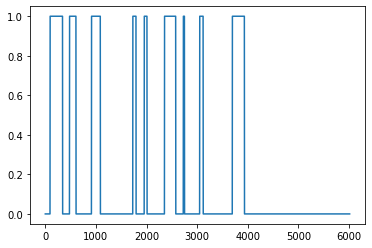

In [11]:
a = np.load("triplet_results/leave_one_out/leave_apple_out.npy", allow_pickle=True).item()
print(a['model path'])
plt.plot(a['labels'])

In [38]:
labels = np.concatenate(labels)
print(labels.shape)


(6013,)


In [39]:
import numpy as np
encodings = np.vstack(encodings)
print(encodings.shape)
from sklearn.manifold import TSNE

test_embedded = TSNE(n_components=2, verbose = 10).fit_transform(encodings)


(6013, 512)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6013 samples in 0.165s...
[t-SNE] Computed neighbors for 6013 samples in 15.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6013
[t-SNE] Computed conditional probabilities for sample 2000 / 6013
[t-SNE] Computed conditional probabilities for sample 3000 / 6013
[t-SNE] Computed conditional probabilities for sample 4000 / 6013
[t-SNE] Computed conditional probabilities for sample 5000 / 6013
[t-SNE] Computed conditional probabilities for sample 6000 / 6013
[t-SNE] Computed conditional probabilities for sample 6013 / 6013
[t-SNE] Mean sigma: 0.519735
[t-SNE] Computed conditional probabilities in 0.238s
[t-SNE] Iteration 50: error = 90.5258560, gradient norm = 0.0231965 (50 iterations in 2.669s)
[t-SNE] Iteration 100: error = 78.5806427, gradient norm = 0.0051280 (50 iterations in 1.997s)
[t-SNE] Iteration 150: error = 77.5951080, gradient norm = 0.0027634 (50 iterations in 2.014s)
[t-SNE] Iteration 

['Apple' 'Cherry_(including_sour)' 'Corn_(maize)' 'Grape' 'Peach'
 'Pepper,_bell' 'Potato' 'Strawberry' 'Tomato']
Apple
Cherry_(including_sour)
Corn_(maize)
Grape
Peach
Pepper,_bell
Potato
Strawberry
Tomato


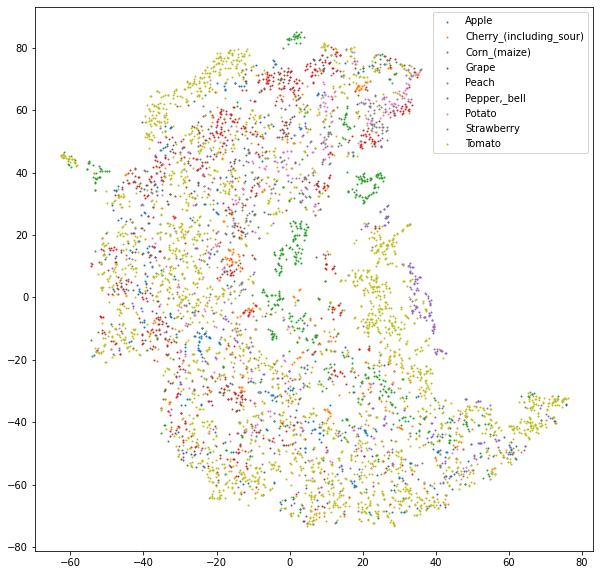

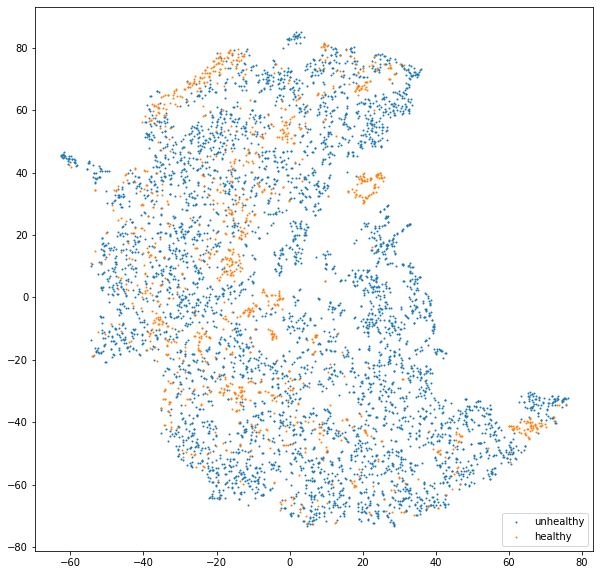

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

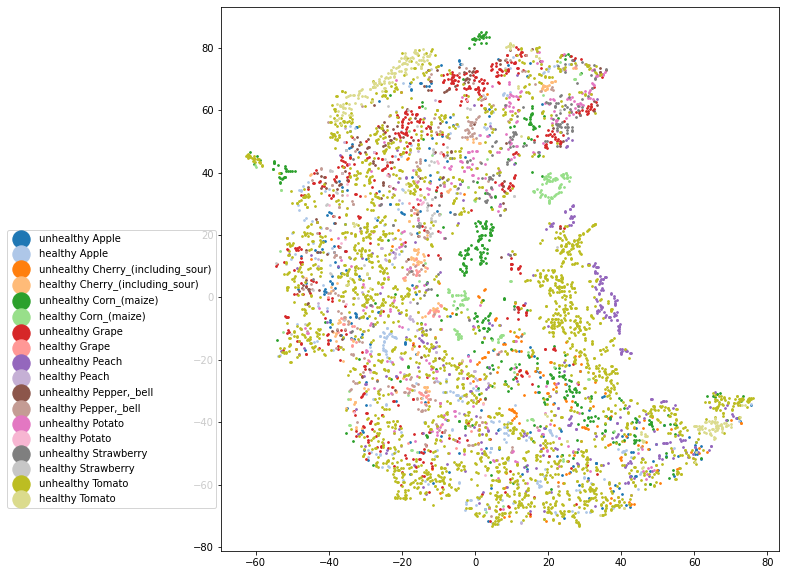

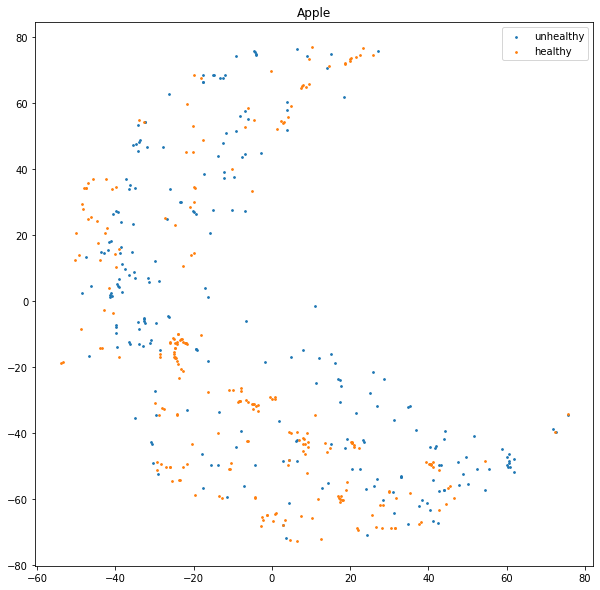

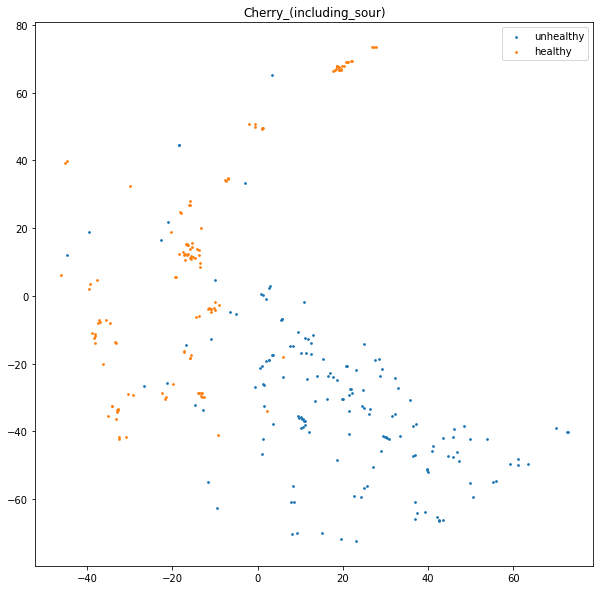

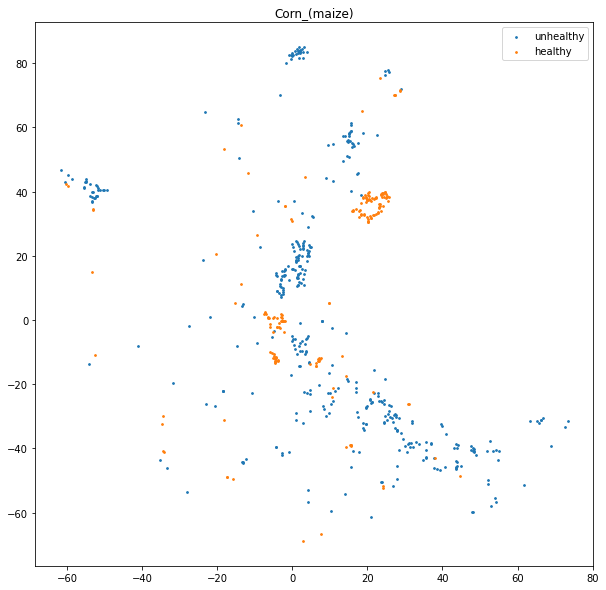

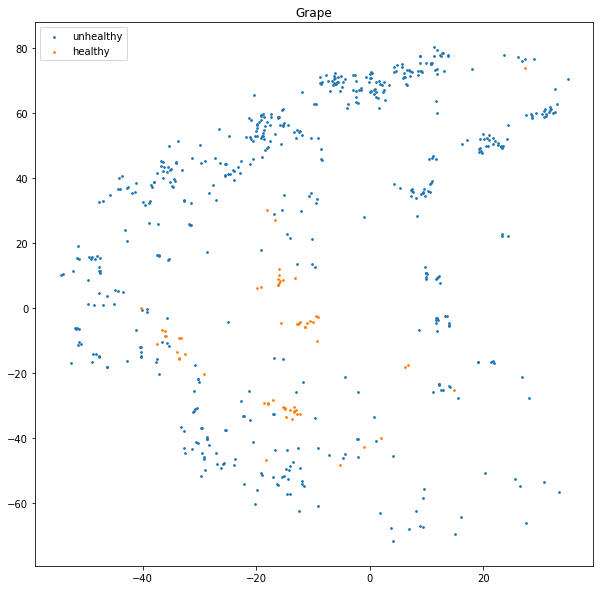

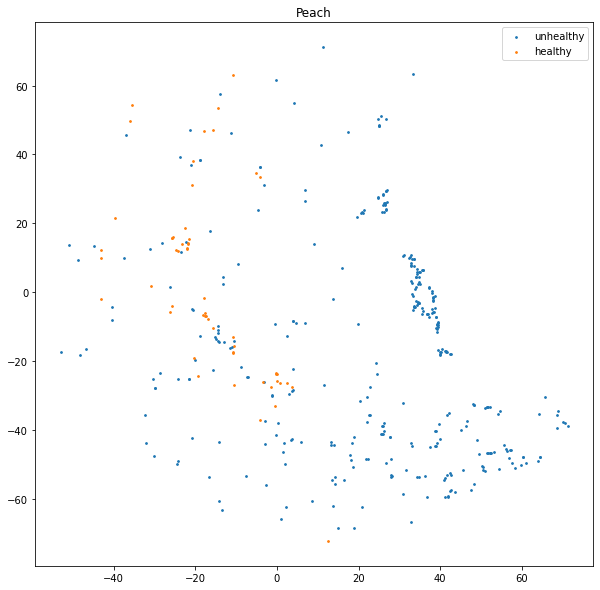

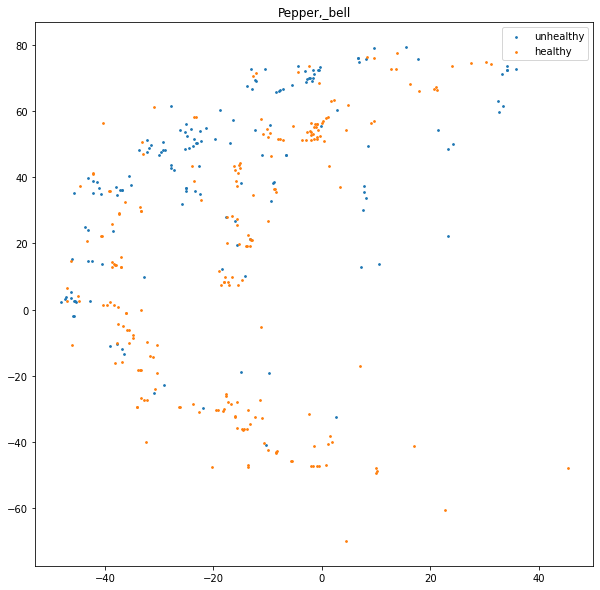

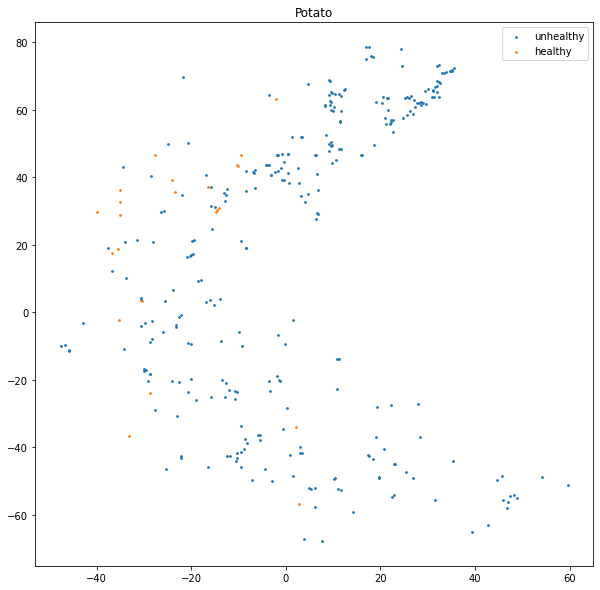

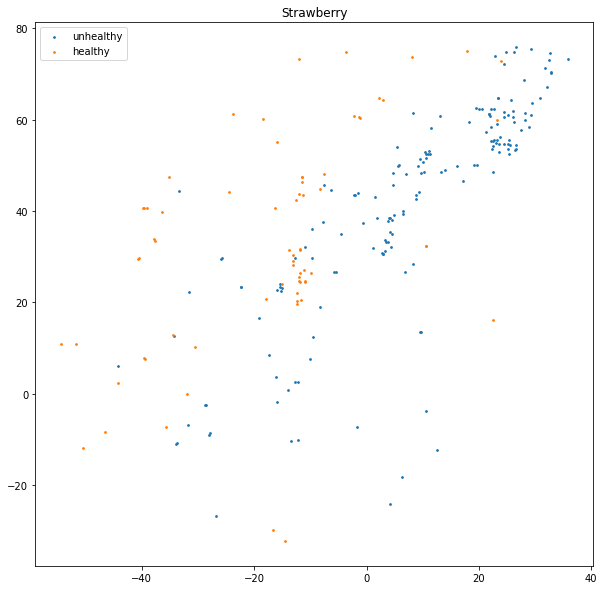

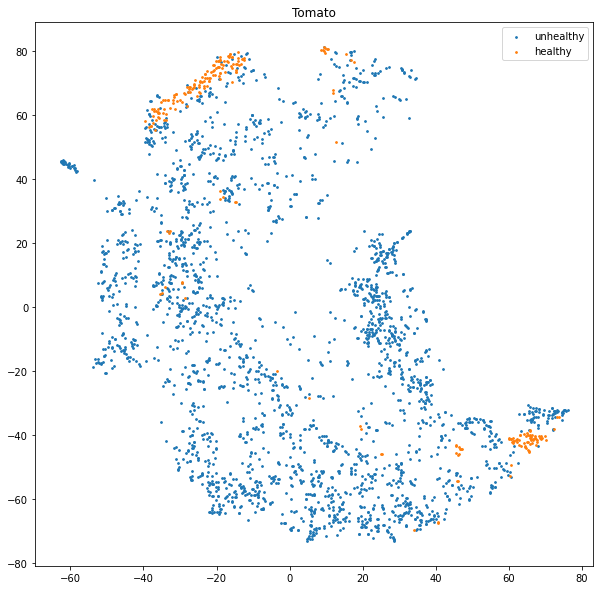

In [40]:
plt.figure(figsize=(10,10))
plant_names = np.unique(names)
print(plant_names)
names = np.array(names)
for plant_name in plant_names:
    print(plant_name)
    plt.scatter(test_embedded[names==plant_name,0], test_embedded[names==plant_name,1], s = 1, label=plant_name)
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for health in [0,1]:
    plt.scatter(test_embedded[labels==health,0], test_embedded[labels==health,1], s = 1, label="healthy" if health==1 else "unhealthy")
plt.legend(loc='lower right')
plt.show()


cmap = plt.get_cmap("tab20")
plt.figure(figsize=(10,10))
for pidx, plant in enumerate(plant_names):
    for health in [0,1]:
        selection = np.logical_and(labels==health, names==plant)
        plt.scatter(test_embedded[selection,0], test_embedded[selection,1], s = 3, c = cmap(pidx*2 + health),
                    label="healthy {}".format(plant) if health==1 else "unhealthy {}".format(plant))
    #plt.title(plant)
plt.legend(bbox_to_anchor = (0, 0.6), markerscale=10)
plt.show()

for plant in plant_names:
    plt.figure(figsize=(10,10))
    for health in [0,1]:
        selection = np.logical_and(labels==health, names==plant)
        plt.scatter(test_embedded[selection,0], test_embedded[selection,1], s = 3, label="healthy" if health==1 else "unhealthy")
    plt.title(plant)
    plt.legend()
    plt.show()

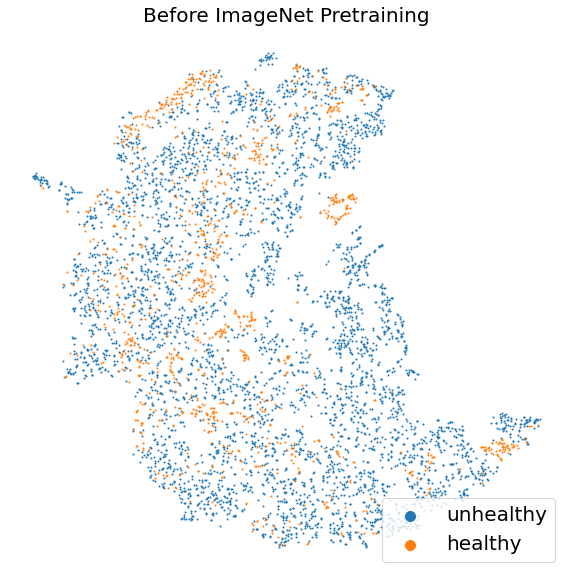

In [42]:
plt.figure(figsize=(10,10))
for health in [0,1]:
    plt.scatter(test_embedded[labels==health,0], test_embedded[labels==health,1], s = 1, label="healthy" if health==1 else "unhealthy")
plt.legend(loc='lower right', fontsize = 20, markerscale = 10)
plt.gca().set_axis_off()
plt.title("Before ImageNet Pretraining", fontsize=20)
plt.show()

In [25]:
from sklearn.neural_network import MLPClassifier
training_idxs = names == "Apple"#np.logical_or(np.logical_or(names == "Tomato", names=="Potato"), names == "Strawberry")
clf = MLPClassifier(random_state=1, max_iter=300, verbose = 10).fit(encodings[np.logical_not(training_idxs)], labels[np.logical_not(training_idxs)])


Iteration 1, loss = 0.13711549
Iteration 2, loss = 0.07159697
Iteration 3, loss = 0.06817082
Iteration 4, loss = 0.07189146
Iteration 5, loss = 0.06165591
Iteration 6, loss = 0.05934568
Iteration 7, loss = 0.06054603
Iteration 8, loss = 0.05535936
Iteration 9, loss = 0.05718652
Iteration 10, loss = 0.05297562
Iteration 11, loss = 0.05498139
Iteration 12, loss = 0.04776373
Iteration 13, loss = 0.04489160
Iteration 14, loss = 0.04288351
Iteration 15, loss = 0.04346257
Iteration 16, loss = 0.04132317
Iteration 17, loss = 0.04417288
Iteration 18, loss = 0.03956588
Iteration 19, loss = 0.04022757
Iteration 20, loss = 0.04296115
Iteration 21, loss = 0.03804533
Iteration 22, loss = 0.03779402
Iteration 23, loss = 0.04266179
Iteration 24, loss = 0.03797003
Iteration 25, loss = 0.03429545
Iteration 26, loss = 0.03944720
Iteration 27, loss = 0.03264458
Iteration 28, loss = 0.03288856
Iteration 29, loss = 0.03488154
Iteration 30, loss = 0.03412460
Iteration 31, loss = 0.03092085
Iteration 32, los

In [26]:
for test_plant in ["Apple"]:
    predictions = np.argmax(clf.predict_proba(encodings[names == test_plant]), axis = 1)
    gt = labels[names == test_plant]
    from sklearn.metrics import confusion_matrix
    print(test_plant)
    print(confusion_matrix(predictions, gt))

Apple
[[212  73]
 [ 19 174]]
